This notebook outlines the steps of a time domain reflectometry algorithm that is used to process signals sampled using a Raspberry Pi based Time Domain Reflectometer (TDR) to detect faults in electric cables, determine their type and point of occurrence. The algorithm checks for presence of a reflected signal in the sampled signal to detect a fault. The interference between the incident and reflected signal result in change points on the sampled signal. The time domain reflectometry uses the method of discrete gradient to locate the change points.

In [1]:
import os
import time
import numpy as np
import configparser
import pandas as pd
import tdr_utils as td
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('parameters.ini')

c = float(config['signal']['c']) #velocity of light
v_peak = int(config['signal']['v_peak']) #v_peak
st_dev = float(config['signal']['st_dev']) #standard deviation of the fast-rising rectangular pulse
pulse_freq = float(config['signal']['pulse_freq'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

a_vf = float(config['thresholds']['a_vf']) #approximate velocity factor for window size setting
rising_edge_v = int(config['thresholds']['rising_edge_v'])
negative_threshold = int(config['thresholds']['negative_threshold'])
reflection_edge_threshold = float(config['thresholds']['reflection_edge_threshold'])

#dekut conservancy
dekutwc_D = float(config['dekutwc']['D']) #cable's distance of separation 
dekutwc_r = float(config['dekutwc']['r']) #radius of the cables
dekutwc_c_len = int(config['dekutwc']['c_len'])
dekutwc_win_size = int(((dekutwc_c_len * 2) / (a_vf * c)) * sampling_rate) #window size to search for change points


#olpejeta conservancy
olpejeta_D = float(config['olpejeta']['D']) #cable's distance of separation 
olpejeta_r = float(config['olpejeta']['r']) #radius of the cables
olpejeta_c_len = int(config['olpejeta']['c_len'])
olpejeta_win_size = int(((olpejeta_c_len * 2) / (a_vf * c)) * sampling_rate) #window size to search for change points


t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

In [3]:
#files' paths

files_paths = []
root_path = '..\data'

folders = os.listdir(root_path)

for folder in folders:

    for dir_path, _, file_names in os.walk(os.path.join(root_path, folder)):
        if len(file_names) > 0:            
            files_paths += [os.path.join(dir_path, file) for file in file_names]       

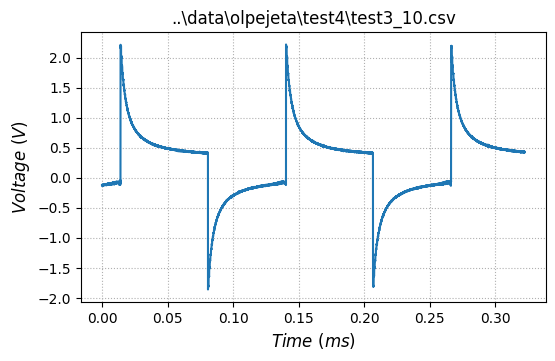

In [4]:
#load and plot a random file

file_path, v = td.random_file_load(files_paths, num_samples, v_peak)

td.graph_plot(t, v, file_path, (6,3.5))

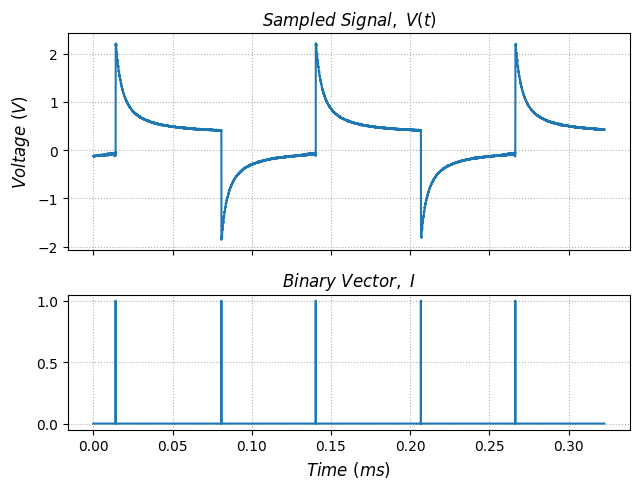

87


In [5]:
#identify where file was collected (olpejeta / dekutwc) to specify parameters

if 'olpejeta' in file_path:
    win_size = olpejeta_win_size
    c_len = olpejeta_c_len
    D = olpejeta_D
    r = olpejeta_r
    actual_dist = {'test1': 280.6, 'test2':12.2, 'test3':36.6, 'test4':67.1, 'test5':97.6,
                     'test6':128.1, 'test7':158.6, 'test8':189.1, 'test9':219.6, 'test10':250.1, 'test11':280.6}
    
else:
    win_size = dekutwc_win_size
    c_len = dekutwc_c_len
    D = dekutwc_D
    r = dekutwc_r
    actual_dist = {'test1': 106.38, 'test2':12.41, 'test3':17.44, 'test4':22.38, 'test5':26.86,
                     'test6':32.24, 'test7':37.61, 'test8':42.15, 'test9':47.35, 'test10':52.11, 
                     'test11':57.08, 'test12':62.05, 'test13':66.93, 'test14':72.10, 'test15':77.00,
                     'test16':82.03, 'test17':87.52, 'test18':93.26, 'test19':98.56, 'test20':104.26}
    
if 'test1' in file_path:
    expected_fault = 'Open Circuit'
else:
    expected_fault = 'Short Circuit'
    
#locate rising and falling edges of incident signal
edges, e_indices, fault_type = td.edge_detection(v, 
                                                 st_dev, 
                                                 pulse_freq, 
                                                 duty_cycle, 
                                                 sampling_rate, 
                                                 rising_edge_v, 
                                                 num_samples, 
                                                 win_size, 
                                                 negative_threshold)

td.edges_plot(t, v, edges)

print(win_size)

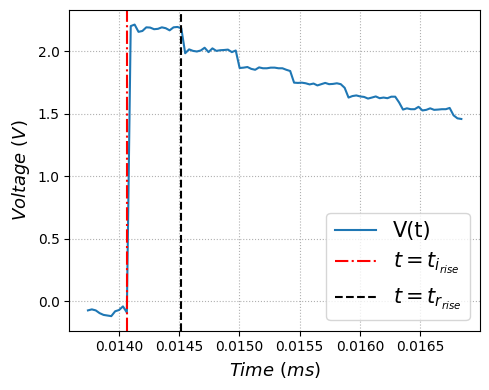

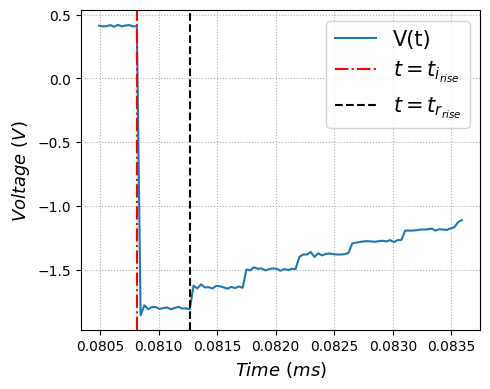

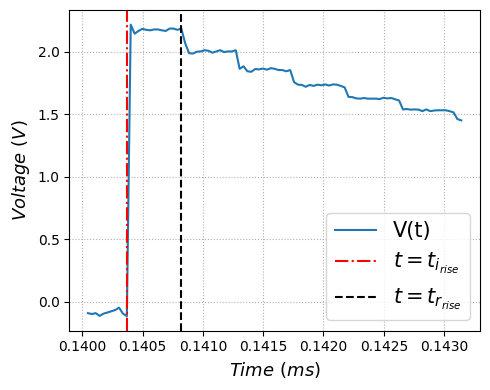

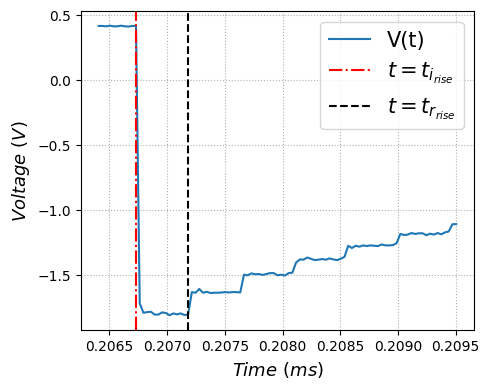

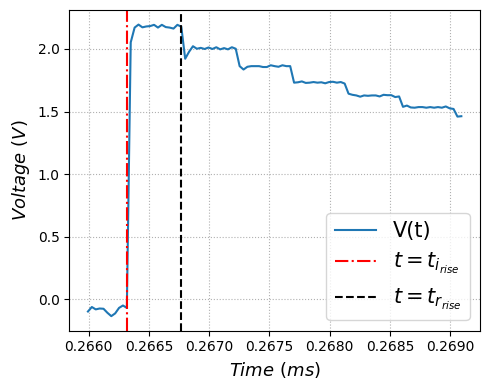

In [6]:
#locate changepoints due to reflected signal and plot

cp_indices, segs_interest = td.changepoint(v, 
                                           c_len, 
                                           e_indices, 
                                           sampling_rate, 
                                           c, 
                                           a_vf, 
                                           win_size, 
                                           reflection_edge_threshold)

td.cp_plot(t, v, segs_interest, win_size)

In [7]:
#obtain time delay and compute distance to fault

t_delays, avg_t_delay = td.time_delay(t, segs_interest)
predicted_dist = round(td.fault_point(avg_t_delay, c, D, r), 2)

In [8]:
#tdr algorithm performance

test = file_path.split('\\')[3]
expected_dist = actual_dist[test]

absolute_error = round(td.performance_metrics(expected_dist, predicted_dist, metrics=['mae']).mae, 2)

start = '\033[1m'
end = '\033[0;0m'

print('Expected fault is: {}. Predicted fault is: {}.'.format(start + expected_fault + end, start + fault_type + end))
print('Expected distance to fault is: {}. Predicted distance to fault is: {}. The absolute error is {}.'
      .format(start + str(expected_dist) + ' m' + end, 
              start + str(predicted_dist) + ' m' + end, 
              start + str(absolute_error) + ' m' + end))

Expected fault is: Short Circuit. Predicted fault is: Short circuit.
Expected distance to fault is: 67.1 m. Predicted distance to fault is: 66.1 m. The absolute error is 1.0 m.
